In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    GlobalAveragePooling2D, Dense, Dropout, 
    BatchNormalization, GaussianNoise, Input
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

In [2]:
dataset_path ="/kaggle/input/oral-cancer/dataset"
batch_size = 32
img_size = (224, 224)
channels = 3
input_shape = img_size + (channels,)

In [3]:
tr_datagen = ImageDataGenerator(rescale=1.0 / 255)
val_datagen = ImageDataGenerator(rescale=1.0 / 255)
ts_datagen = ImageDataGenerator(rescale=1.0 / 255)

train_gen = tr_datagen.flow_from_directory(
    os.path.join(dataset_path, "train"),
    target_size=img_size,
    batch_size=batch_size,
    class_mode="binary",
    color_mode="rgb",
    shuffle=True,
)

val_gen = val_datagen.flow_from_directory(
    os.path.join(dataset_path, "val"),
    target_size=img_size,
    batch_size=batch_size,
    class_mode="binary",
    color_mode="rgb",
    shuffle=True,
)

test_gen = ts_datagen.flow_from_directory(
    os.path.join(dataset_path, "test"),
    target_size=img_size,
    batch_size=batch_size,
    class_mode="binary",
    color_mode="rgb",
    shuffle=False,
)

Found 3633 images belonging to 2 classes.
Found 519 images belonging to 2 classes.
Found 1040 images belonging to 2 classes.


In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Activation
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

model = Sequential()

# Block 1
model.add(Conv2D(32, (3, 3), padding='same', input_shape=(224, 224, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))

# Block 2
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))

# Block 3
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))

# Block 4
model.add(Conv2D(256, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(256, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))

# Block 5
model.add(Conv2D(512, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(512, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))

#Block 6
model.add(Conv2D(1024, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))

# Classification head
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [5]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 224, 224, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 224, 224, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 224, 224, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 224, 224, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 224, 224, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 112, 112, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 56, 56, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 56, 56, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 56, 56, 128)         │             5

 Total params: 14,327,329 (54.65 MB)

 Trainable params: 14,321,313 (54.63 MB)

 Non-trainable params: 6,016 (23.50 KB)

In [ ]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


114/114 ━━━━━━━━━━━━━━━━━━━━ 137s 891ms/step - accuracy: 0.6107 - loss: 0.7501 - val_accuracy: 0.5087 - val_loss: 0.6923
Epoch 2/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 48s 413ms/step - accuracy: 0.7539 - loss: 0.5204 - val_accuracy: 0.4798 - val_loss: 1.3661
Epoch 3/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 48s 410ms/step - accuracy: 0.7851 - loss: 0.4516 - val_accuracy: 0.5029 - val_loss: 0.9324
Epoch 4/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 49s 421ms/step - accuracy: 0.8188 - loss: 0.3892 - val_accuracy: 0.6879 - val_loss: 0.5646
Epoch 5/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 49s 423ms/step - accuracy: 0.8419 - loss: 0.3478 - val_accuracy: 0.7938 - val_loss: 0.4253
Epoch 6/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 48s 412ms/step - accuracy: 0.8474 - loss: 0.3194 - val_accuracy: 0.7688 - val_loss: 0.6432
Epoch 7/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 48s 418ms/step - accuracy: 0.8635 - loss: 0.2907 - val_accuracy: 0.7919 - val_loss: 0.6063
Epoch 8/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 48s 414ms/step - accuracy: 0.8708 - loss: 0.2719 - va

In [9]:
def evaluate_model(model, train_gen, val_gen, test_gen, history):
    train_res = model.evaluate(train_gen)
    train_accuracy = train_res[1]
    print(f"Training Accuracy: {train_accuracy * 100:.2f}%")
    
    val_res = model.evaluate(val_gen)
    val_accuracy = val_res[1]
    print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")
    
    test_res = model.evaluate(test_gen)
    test_accuracy = test_res[1]
    print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
    
    y_true = test_gen.classes
    y_pred_prob = model.predict(test_gen)
    
    if y_pred_prob.shape[1] > 1:
        y_pred = np.argmax(y_pred_prob, axis=1)
    else:
        y_pred = (y_pred_prob > 0.5).astype(int).flatten()
    
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
                xticklabels=test_gen.class_indices.keys(), 
                yticklabels=test_gen.class_indices.keys())
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()
    
    print("Classification Report:\n", classification_report(y_true, y_pred, target_names=test_gen.class_indices.keys()))
    
    if history is not None:
        plt.figure(figsize=(8, 6))
        plt.plot(history.history.get('loss', []), label='Train Loss', marker='o')
        plt.plot(history.history.get('val_loss', []), label='Validation Loss', marker='s')
        plt.title('Model Loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend()
        plt.grid()
        plt.show()
    
    if y_pred_prob.shape[1] == 1:
        fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
        roc_auc = auc(fpr, tpr)
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC Curve (AUC = {roc_auc:.2f})")
        plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC Curve")
        plt.legend(loc="lower right")
        plt.show()


114/114 ━━━━━━━━━━━━━━━━━━━━ 16s 136ms/step - accuracy: 0.9450 - loss: 0.1306
Training Accuracy: 94.55%
17/17 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.8783 - loss: 0.6047
Validation Accuracy: 86.51%
33/33 ━━━━━━━━━━━━━━━━━━━━ 31s 921ms/step - accuracy: 0.8994 - loss: 0.4113
Test Accuracy: 90.96%
33/33 ━━━━━━━━━━━━━━━━━━━━ 31s 886ms/step


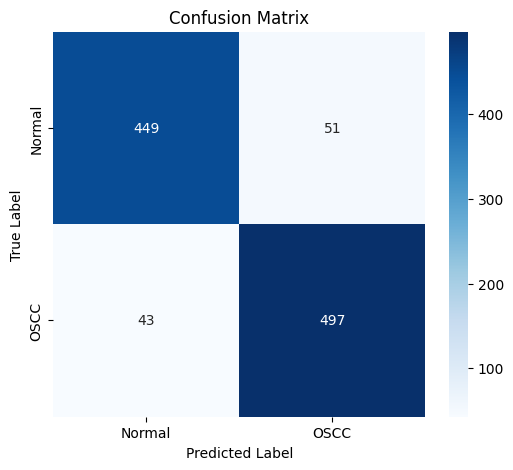

Classification Report:
               precision    recall  f1-score   support

      Normal       0.91      0.90      0.91       500
        OSCC       0.91      0.92      0.91       540

    accuracy                           0.91      1040
   macro avg       0.91      0.91      0.91      1040
weighted avg       0.91      0.91      0.91      1040



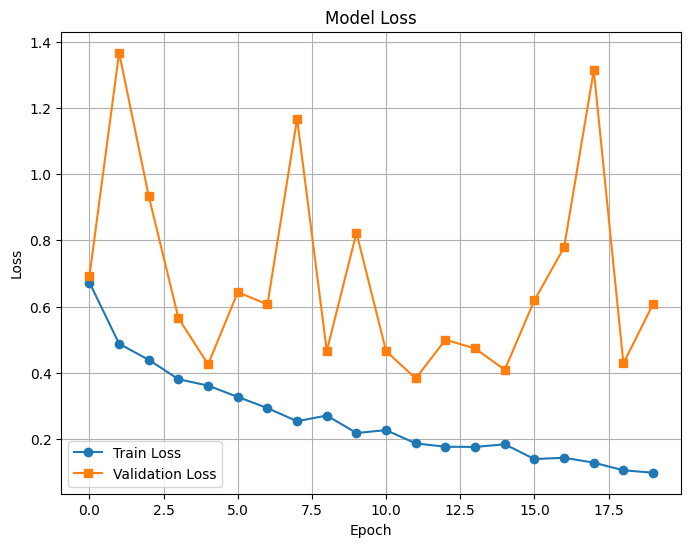

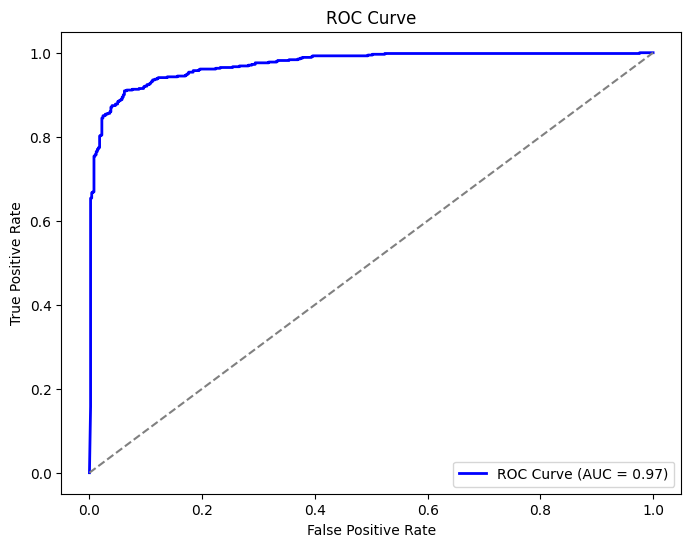

In [11]:
evaluate_model(model,train_gen, val_gen, test_gen, history)

In [12]:
model.save('model.keras')
print("Model saved")

Model saved
